In [97]:
import sys

# sys.path.clear()  # Clear all paths
# sys.path.remove('./path/to/remove') # Remove a selected path

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Active Learning path
AL_PATH = basepath + "04_Active_Learning/"

# Data
DATA_PATH = basepath + "data/"

# Path to conda environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Resultspath
RESULTS_PATH = AL_PATH + "results/"

# Figure
FIGURE_PATH = RESULTS_PATH + "figures/"

# AL Scripts
AL_SCRIPTS_PATH = basepath + "al_scripts"

# Logging
LOG_DIR = AL_PATH + "logs/"

# Add the paths
sys.path.extend({DATA_PATH, FIGURE_PATH, ENV_PATH, RESULTS_PATH, AL_SCRIPTS_PATH})

# remove a selected path
# sys.path.remove('')

sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '../04_Active_Learning/results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/figures/',
 '../data/',
 '../al_scripts',
 '../',
 '../04_Active_Learning/results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/figures/',
 '../data/',
 '../al_scripts',
 '../',
 '../04_Active_Learning/results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/figures/',
 '../data/',
 '../al_scripts']

### Logging

In [98]:
LOG_DIR

'../04_Active_Learning/logs/'

In [99]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "04_active_learning_pls.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"
# print(f"Log file path: {log_file_path}")

# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")

2024-06-20 17:45:55 - INFO - Logging started


## Import Packages

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge as KRR
import pandas as pd

In [101]:
## Turn of sklearn warnings
from warnings import simplefilter
import warnings

from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(
    "ignore", message=".*y residual is constant*.", category=UserWarning, append=False
)

### Import Data

#### Import PS20191107_2deriv_gegl.csv

(array([115.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  18.,  33.,   8.,  28.,  16.,   1.,  11.,  18.,
         53.,  21.,  12.,  51.,   5.,  26.,  50.,  21.,  35.,  82.,  36.,
         67., 116.,  88., 109., 410., 807.]),
 array([-13555.  , -13243.72, -12932.44, -12621.16, -12309.88, -11998.6 ,
        -11687.32, -11376.04, -11064.76, -10753.48, -10442.2 , -10130.92,
         -9819.64,  -9508.36,  -9197.08,  -8885.8 ,  -8574.52,  -8263.24,
         -7951.96,  -7640.68,  -7329.4 ,  -7018.12,  -6706.84,  -6395.56,
         -6084.28,  -5773.  ,  -5461.72,  -5150.44,  -4839.16,  -4527.88,
         -4216.6 ,  -3905.32,  -3594.04,  -3282.76,  -2971.48,  -2660.2 ,
         -2348.92,  -2037.64,  -1726.36,  -1415.08,  -1103.8 ,   -792.52,
          -481.24,   -169.96,    141.32,    452.6 ,    763.88,   1075.16,
          1386.44,   1697.72,   2009.  ]),
 <BarContainer object o

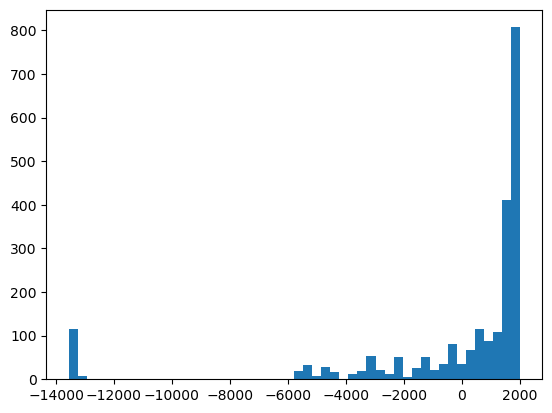

In [102]:
# Import 2nd_deriv

data_2nd_deriv_raw = pd.read_csv(
    DATA_PATH + "/PS20191107_2deriv_gegl.csv",
    on_bad_lines="skip",
    sep=";",
    decimal=",",
    encoding="utf-8",
)

# plot distribution of age in histogram
plt.hist(data_2nd_deriv_raw["year"], bins=50)

2024-06-20 17:45:58 - INFO - Amount of samples with age older than -6000 in PS2019: 122


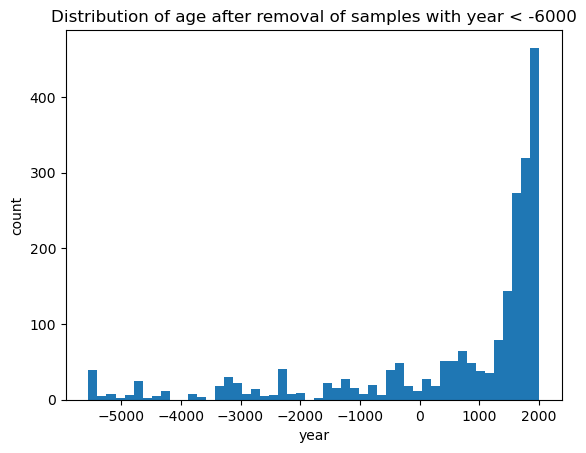

In [103]:
# reduction of the dataset to exlude samples with age larger than >-5000

# count the amount of samples with age larger than -5000
logging.info(
    f"Amount of samples with age older than -6000 in PS2019: {len(data_2nd_deriv_raw[data_2nd_deriv_raw['year'] < -6000])}"
)
# remove these samples
data_2nd_deriv_raw = data_2nd_deriv_raw[data_2nd_deriv_raw["year"] > -6000]
# plot distribution of age in histogram
plt.hist(data_2nd_deriv_raw["year"], bins=50)
plt.xlabel("year")
plt.ylabel("count")
plt.title("Distribution of age after removal of samples with year < -6000")
plt.savefig(FIGURE_PATH + "/data_vis_PS2019_hist_year_6000cutoff.png")
plt.show()

In [104]:
data_2nd_deriv = data_2nd_deriv_raw.rename(columns={"Unnamed: 0": "Name"})

# Convert all columns of type 'object' to 'float' or 'int' if possible
for column in data_2nd_deriv.columns:
    # change datatype from the 'year' column to 'int
    if column == "year":
        data_2nd_deriv[column] = data_2nd_deriv[column].astype("int")
        print(f"'{column}' has been converted to 'int'.")
        # skip the rest of the loop
        continue
    try:
        data_2nd_deriv[column] = data_2nd_deriv[column].astype("float")
        # data_small.select_dtypes(include=['object']).astype('float')
    except ValueError:
        print(f"'{column}' could not be converted. Continue with other column(s).")
    except TypeError:
        print(f"'{column}' could not be converted. Continue with other column(s).")

'Name' could not be converted. Continue with other column(s).
'year' has been converted to 'int'.
'Origin' could not be converted. Continue with other column(s).
'type' could not be converted. Continue with other column(s).


### Import dpsDeriv1200.csv

In [105]:
data_dps_deriv_1200 = pd.read_csv(
    DATA_PATH + "/dpsDeriv1200.csv", sep=",", decimal=".", encoding="utf-8"
)
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns=lambda x: x.replace("X", ""))
data_dps_deriv_1200

,Unnamed: 0,year,tree,Origin,type,2970,2968,2966,2964,2962,...,818,816,814,812,810,808,806,804,802,800
0,2GOS-18_1955,1955,2GOS-18,POL,living,-7.236150e-08,4.010600e-07,0.000005,1.310370e-05,1.788600e-05,...,-4.740000e-06,-0.000020,-0.000034,-0.000045,-0.000052,-0.000054,-0.000049,-0.000038,-0.000023,-0.000011
1,2GOS-18_1969,1969,2GOS-18,POL,living,1.739940e-05,4.649250e-06,-0.000007,-1.769050e-05,-2.597300e-05,...,-2.730000e-07,-0.000016,-0.000031,-0.000042,-0.000046,-0.000045,-0.000040,-0.000031,-0.000019,-0.000007
2,2GOS-18_1974,1974,2GOS-18,POL,living,1.629130e-05,1.129150e-05,0.000006,5.111420e-07,-5.256790e-06,...,-1.890000e-06,-0.000014,-0.000025,-0.000036,-0.000043,-0.000046,-0.000043,-0.000035,-0.000023,-0.000013
3,2GOS-18_1976,1976,2GOS-18,POL,living,9.659060e-06,4.122150e-06,0.000003,4.831610e-06,3.334600e-06,...,-1.630000e-06,-0.000016,-0.000030,-0.000043,-0.000052,-0.000055,-0.000051,-0.000040,-0.000025,-0.000012
4,2GOS-18_1996,1996,2GOS-18,POL,living,9.218540e-06,3.989240e-06,-0.000006,-1.145560e-05,-6.957740e-06,...,2.350000e-07,-0.000010,-0.000023,-0.000037,-0.000047,-0.000052,-0.000050,-0.000044,-0.000035,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,SZLPS15a_1942,1942,SZLPS15a,AUT,living,1.930000e-06,-1.740000e-06,-0.000005,-4.760000e-06,1.920000e-07,...,-9.250000e-06,-0.000026,-0.000041,-0.000054,-0.000063,-0.000064,-0.000059,-0.000047,-0.000032,-0.000016
1286,SZLPS15a_1952,1952,SZLPS15a,AUT,living,1.410000e-06,-4.960000e-06,-0.000010,-6.870000e-06,2.740000e-06,...,-5.970000e-06,-0.000025,-0.000042,-0.000056,-0.000063,-0.000064,-0.000058,-0.000046,-0.000030,-0.000015
1287,SZLPS15a_1962,1962,SZLPS15a,AUT,living,-1.980000e-06,-3.530000e-06,-0.000002,3.120000e-06,9.860000e-06,...,-6.480000e-06,-0.000026,-0.000044,-0.000058,-0.000065,-0.000064,-0.000055,-0.000042,-0.000027,-0.000013
1288,SZLPS15a_1972,1972,SZLPS15a,AUT,living,3.140000e-06,-5.210000e-06,-0.000011,-9.600000e-06,-1.490000e-06,...,-1.120000e-06,-0.000020,-0.000038,-0.000055,-0.000066,-0.000069,-0.000064,-0.000052,-0.000036,-0.000020


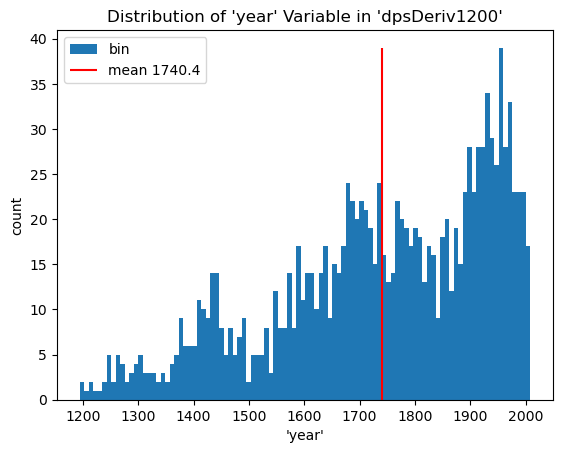

In [106]:

plt.xlabel("'year'")
plt.ylabel("count")
plt.title("Distribution of 'year' Variable in 'dpsDeriv1200'")
# calculate the mean of the 'year' variable
mean_year = round(np.mean(data_dps_deriv_1200["year"]), 1)
# calculate the max count in the histogram
max_count = np.max(plt.hist(data_dps_deriv_1200["year"], bins=100, label= "bin")[0])
plt.vlines(mean_year, 0, max_count, color="red", label=f"mean {mean_year}")
plt.legend()
plt.savefig(FIGURE_PATH + "/data_visualisation_dps1200_hist_year.png")
plt.show()

In [107]:
# Define generarl settings

# Switch for the dataset
# Select from (data_1200, data_full) or other if implemented
data = data_dps_deriv_1200

# Switch for testing mode (use only 10% of the data, among others)
testing = True

# Define a random state for randomized processes
# random_state = np.random.RandomState(202375)
random_state = 202375

######################################################
if testing == True:
    n_jobs = 20
    print("Testing mode for Cross Validation")
    print("consider Splitting the data for faster modelling")
else:
    n_jobs = 40
    print("Extensive mode for Cross Validation")
######################################################

Testing mode for Cross Validation
consider Splitting the data for faster modelling


## Split into feature and target variables

In [108]:
from sklearn.model_selection import train_test_split

X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

## Validation

since not every regression method is able to estimate its prediction accuracy, a split of the data is retained as validation set. 

In [109]:
# count the number of columns with std = 0.0 in X
logging.info(
    f"Number of columns dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}"
)

# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")

2024-06-20 17:46:00 - INFO - Number of columns dropped, where std = 0.0 in X: 0
2024-06-20 17:46:00 - INFO - Dimensions of X after dropping columns with std = 0.0: (1290, 410)
2024-06-20 17:46:00 - INFO - Dimensions of Y: (1290,)


In [110]:
# retain 10% of the data for validation
(
    X_remainder,
    X_val,
    y_remainder,
    y_val,
) = train_test_split(X, y, test_size=0.1, random_state=random_state)

# split the remainder into training and test (30%) set
X_train, X_test, y_train, y_test = train_test_split(
    X_remainder, y_remainder, test_size=0.3, random_state=random_state
)
logging.info(f"Split of the dataset into Training, Test and Validation set")

2024-06-20 17:46:00 - INFO - Split of the dataset into Training, Test and Validation set


In [111]:
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0]

In [112]:
# calculate percentage for each set

# set the number of decimal places
calc = lambda x: round(x / len(X), 2)

# log the information
logging.info(f"Training set: {len(X_train)} ({calc(len(X_train))*100}%)")
logging.info(f"Test set: {len(X_test)} ({calc(len(X_test))*100}%)")
logging.info(f"Validation set:{len(X_val)} ({calc(len(X_val))*100}%)")

2024-06-20 17:46:00 - INFO - Training set: 812 (63.0%)
2024-06-20 17:46:00 - INFO - Test set: 349 (27.0%)
2024-06-20 17:46:00 - INFO - Validation set:129 (10.0%)


## Define Score metrics

In [113]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
# scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
logging.info(f"Scorer: {scoring}")

2024-06-20 17:46:00 - INFO - Scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


## Implementation of AL with IDW (Bemporad, 2023).

This implementation tries to implement the IDW starting from 3.1 Initialization

### Kmeans Setup

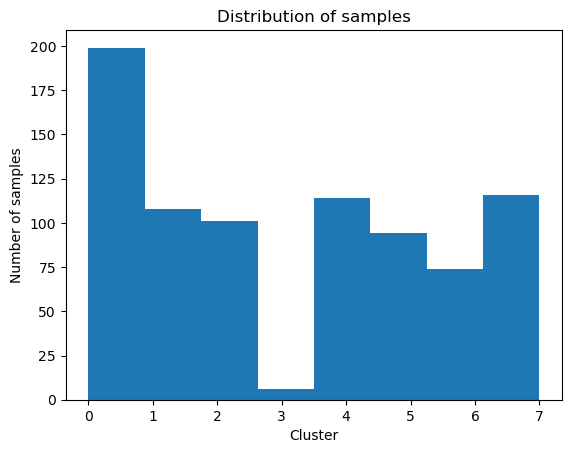

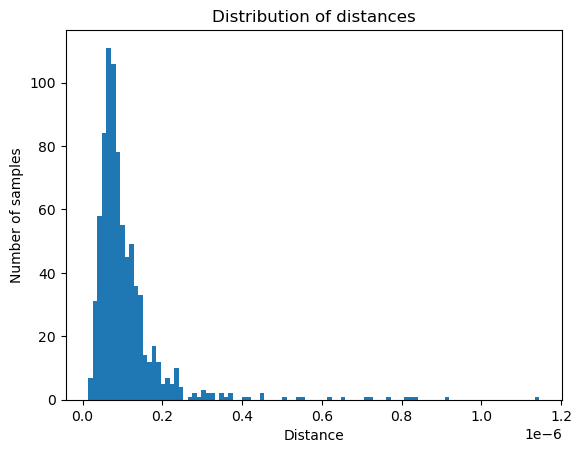

In [114]:
# select N samples for initial modelling via kmeans clustering
# the distances to the cluster centers can be used to select the most
# informative samples for the initial training set

n_samples = len(X_train) // 100  # 1% of the training set
# // floor devision - rounds to the nearest whole number

from sklearn.cluster import KMeans

# alternatively the number of initial clusters can be defined manually
kmeans_clusters = n_samples

# define the kmeans model
kmeans = KMeans(n_clusters=n_samples, random_state=random_state)
# run the kmeans model on the training set
kmeans.fit(X_train)
# get the cluster centers
cluster_centers = kmeans.cluster_centers_

# calculate the distance of each sample to the cluster centers as
# squared (scaled) euclidean distance
from sklearn.metrics.pairwise import euclidean_distances

distances = euclidean_distances(X_train, cluster_centers, squared=True)

stepsize = 1

# return the indizes of the samples that are closest to the cluster centers
dist_sq_eu_argmin = np.argmin(distances, axis=1)

# plot the distribution of the samples
plt.hist(dist_sq_eu_argmin, bins=kmeans_clusters)
plt.title("Distribution of samples")
plt.xlabel("Cluster")
plt.ylabel("Number of samples")
plt.savefig(FIGURE_PATH + "/kmeans_cluster_distr.png")
plt.show()

# plot the distances of the samples to the cluster centers
plt.hist(np.min(distances, axis=1), bins=100)
plt.title("Distribution of distances")
plt.xlabel("Distance")
plt.ylabel("Number of samples")
plt.savefig(FIGURE_PATH + "/kmeans_cluster_distances.png")
plt.show()

### PCA Setup

In [115]:
# create a pca plot of the samples
from sklearn.decomposition import PCA

# store the explained variance ratio
explained_variance_ratio = []

for i in range(2, 14):
    pca = PCA(n_components=i, random_state=random_state)
    X_train_pca = pca.fit_transform(X_train)
    explained_variance_ratio.append(pca.explained_variance_ratio_)
    # retain the information if i == 2 for plotting 2 Dimensional PCA
    if i == 2:
        X_train_pca_2 = X_train_pca

# calculate the sum of explained var for each pca component

# show the table of explained variance ratio
explained_variance_ratio = pd.DataFrame(explained_variance_ratio)

explained_variance_ratio["explained_variance"] = explained_variance_ratio.sum(axis=1)

# save the explained variance ratio as a csv file
explained_variance_ratio.to_csv(
    RESULTS_PATH + "/pca_explained_variance_ratio.csv", index=False
)

explained_variance_ratio.head(n=14)

,0,1,2,3,4,5,6,7,8,9,10,11,12,explained_variance
0,0.321296,0.167968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.489264
1,0.321296,0.167968,0.139143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.628407
2,0.321296,0.167968,0.139143,0.067251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695658
3,0.321296,0.167968,0.139143,0.067251,0.047526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.743184
4,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780853
5,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,0.034064,NaN,NaN,NaN,NaN,NaN,NaN,0.814917
6,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,0.034064,0.028091,NaN,NaN,NaN,NaN,NaN,0.843008
7,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,0.034064,0.028091,0.020629,NaN,NaN,NaN,NaN,0.863637
8,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,0.034064,0.028091,0.020629,0.013978,NaN,NaN,NaN,0.877615
9,0.321296,0.167968,0.139143,0.067251,0.047526,0.037669,0.034064,0.028091,0.020629,0.013978,0.011908,NaN,NaN,0.889522


<function matplotlib.pyplot.show(close=None, block=None)>

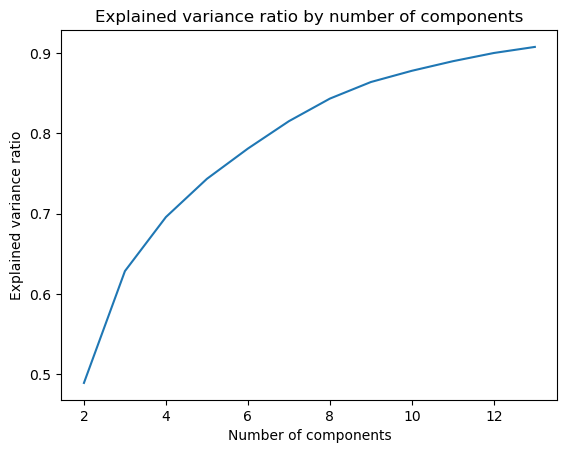

In [116]:
# create the elbow plot

# plot the sum of explained variance ratio against number of components
plt.plot(range(2, 14), explained_variance_ratio["explained_variance"])
plt.title("Explained variance ratio by number of components")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.savefig(FIGURE_PATH + "/pca_elbow_plot.png")
plt.show

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


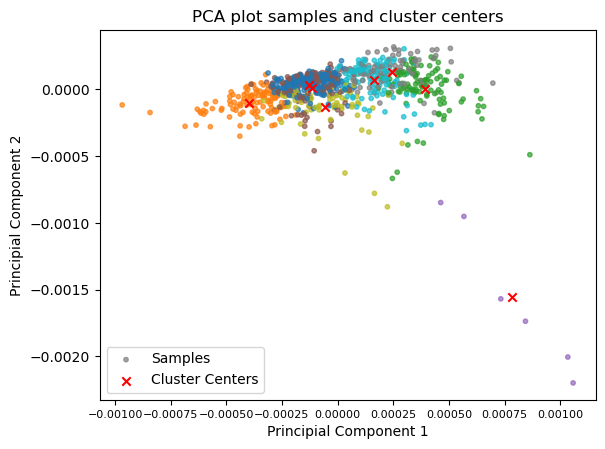

In [117]:
# plot the distances from the cluster centers in 2D
# he cluster centers were calculated in the original feature space

plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=dist_sq_eu_argmin, cmap='tab10', alpha=0.7, s=10)
# transparency of the markers were added to grasp overlapping samples

# highlight the cluster centers
plt.scatter(
    pca.transform(cluster_centers)[
        :, 0
    ],  # transform the cluster centers to the pca space for pc 1
    pca.transform(cluster_centers)[:, 1],
    c="red",
    marker="x",
)
plt.title("PCA plot samples and cluster centers")
plt.xlabel("Principial Component 1")
# reduce the size of markers on the x-axis
plt.xticks(fontsize=8)
plt.ylabel("Principial Component 2")

# add a legend explaining the color mapping
plt.legend(["Samples", "Cluster Centers"])
# save the plot
plt.savefig(FIGURE_PATH + "/pca_cluster_centers.png")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

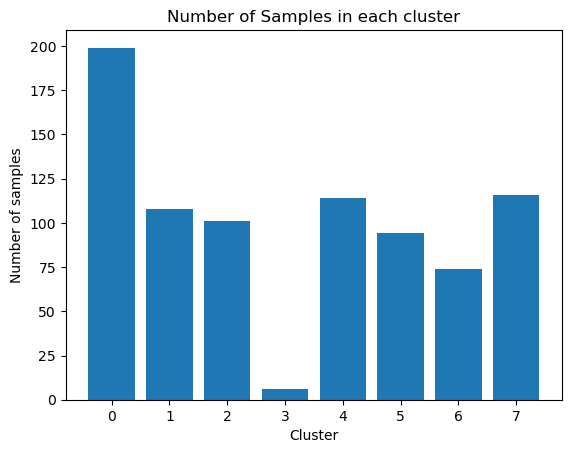

In [118]:
# dist_sq_eu_argmin is the index/name of the cluster center that is closest to each sample
unique, counts = np.unique(dist_sq_eu_argmin, return_counts=True)

# generation of a histogram over the sample distribution in the clusters
plt.bar(unique, counts)
plt.title("Number of Samples in each cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of samples")
plt.savefig(FIGURE_PATH + "/cluster_distribution.png")
plt.show

Closest Sample:  151 0 0
Farthes Sample:  712 3 3


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


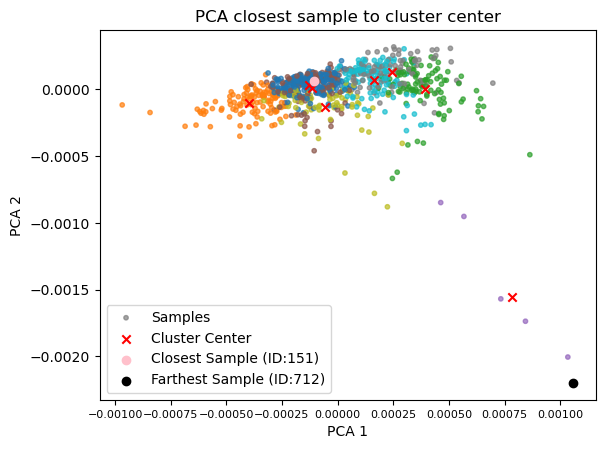

In [119]:
# retrieve the sample id with the smallest distance to any cluster center
# the corresponding sample should be selected as the first sample
id = np.argmin(np.min(distances, axis=1))
id_max = np.argmax(np.max(distances, axis=1))
print("Closest Sample: ", id, dist_sq_eu_argmin[id], np.min(dist_sq_eu_argmin[id]))
print(
    "Farthes Sample: ",
    id_max,
    dist_sq_eu_argmin[id_max],
    np.min(dist_sq_eu_argmin[id_max]),
)

# pcaplot with the highlighted sample
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=dist_sq_eu_argmin, cmap='tab10', alpha=0.7, s=10)

# highlight the cluster centers
plt.scatter(
    pca.transform(cluster_centers)[:, 0],
    pca.transform(cluster_centers)[:, 1],
    c="red",
    marker="x",
)

# highlight the selected sample
plt.scatter(X_train_pca_2[id, 0], X_train_pca_2[id, 1], c="pink", marker="o")
plt.scatter(X_train_pca_2[id_max, 0], X_train_pca_2[id_max, 1], c="black", marker="o")

# Optional plotting possibilities
# annotate the closest sample
# plt.annotate(f"Sample {id}", (X_train_pca_2[id, 0], X_train_pca_2[id, 1]))
# plt.annotate(f"Sample {id_max}", (X_train_pca_2[id_max, 0], X_train_pca_2[id_max, 1]))
# center on the selected sample
# plt.xlim(X_train_pca_2[id, 0] - 0.5, X_train_pca_2[id, 0] + 0.5)
# plt.ylim(X_train_pca_2[id, 1] - 0.5, X_train_pca_2[id, 1] + 0.5)

plt.title("PCA closest sample to cluster center")
plt.xlabel("PCA 1")
plt.xticks(fontsize=8)
plt.ylabel("PCA 2")
plt.legend(
    [
        "Samples",
        "Cluster Center",
        f"Closest Sample (ID:{id})",
        f"Farthest Sample (ID:{id_max})",
    ]
)

# save the plot
plt.savefig(FIGURE_PATH + "/pca_plot_highligh_MinMaxDist.png")
plt.show()

In [120]:
# retrive the indizes of the samples that are closest to each cluster center
kmeans_clusters = n_samples

id = []
initial_samples_sample_ids = []
for i in range(kmeans_clusters):
    id.append(np.where(dist_sq_eu_argmin == i)[0])


# get the first sample of each cluster
for i in range(kmeans_clusters):
    initial_samples_sample_ids.append(id[i][0])
initial_samples_sample_ids

[np.int64(5),
 np.int64(17),
 np.int64(2),
 np.int64(111),
 np.int64(7),
 np.int64(0),
 np.int64(1),
 np.int64(3)]

## Active learning step (first step)

##  Introduction

For each Active Learning we will start with an inital set of samples which allow to generate a model. Based on the employed strategy, additional samples will be added and the model updated. 

**Inital Models**  
[X] random samples  
[X] kmean cluster centers  

**Sampling strategies**  
[X] random sampling  
[ ] euclidean distance  

## Setup

The Active Learning Process in my Workflow recieves the hyperparameters for the model inplementation from the previous process (RSCV and GSCV). 

### Import optimal model parameters from csv

In [121]:
# from 03_1_rscv/rscv_results import pls_rscv_results.csv

# Load the results from the RandomizedSearchCV
pls_rscv_results = pd.read_csv(
    "/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/03_Modelling/03_1_rscv/rscv_results/pls_rscv_results.csv",
    sep=",",
    decimal=".",
    encoding="utf-8",
)
rscv_rmse = pls_rscv_results["RMSE"].idxmin()
# identify the best parameters via the rmse
params_pls = eval(pls_rscv_results.loc[pls_rscv_results["RMSE"].idxmin()].params)
params_pls, rscv_rmse

({'copy': True,
  'max_iter': 339,
  'n_components': 12,
  'scale': True,
  'tol': np.float64(0.6786318868399671)},
 16)

In [122]:
pls_rscv_results.loc[pls_rscv_results["RMSE"].idxmin()].params

"{'copy': True, 'max_iter': 339, 'n_components': 12, 'scale': True, 'tol': np.float64(0.6786318868399671)}"

In [123]:
pls_rscv_results

,model,MAE,RMSE,params
0,PLSRegression(),1373.2620344474878,1884.9152367993017,"{'copy': True, 'max_iter': 680, 'n_components'..."
1,PLSRegression(),1278.0728267325562,1691.6208907481239,"{'copy': True, 'max_iter': 159, 'n_components'..."
2,PLSRegression(),1197.916059570866,1640.3452329150084,"{'copy': True, 'max_iter': 179, 'n_components'..."
3,PLSRegression(),1465.2281144995557,1917.625017076089,"{'copy': True, 'max_iter': 152, 'n_components'..."
4,PLSRegression(),1202.3852194335936,1618.6411988086668,"{'copy': True, 'max_iter': 321, 'n_components'..."
5,model,MAE,RMSE,params
6,PLSRegression(),1373.2620344474878,1884.9152367993017,"{'copy': True, 'max_iter': 680, 'n_components'..."
7,PLSRegression(),1278.0728267325562,1691.6208907481239,"{'copy': True, 'max_iter': 159, 'n_components'..."
8,PLSRegression(),1197.916059570866,1640.3452329150084,"{'copy': True, 'max_iter': 179, 'n_components'..."
9,PLSRegression(),1465.2281144995557,1917.625017076089,"{'copy': True, 'max_iter': 152, 'n_components'..."


In [124]:
# retrive the best parameters as a dictionary

# params_pls = {'n_components': 45, 'max_iter':321}

In [125]:
# Inital model with random samples and pandas dataframes

from sklearn.cross_decomposition import PLSRegression
from al_lib.helper_functions import rmse_func

pls = PLSRegression(**params_pls)

X_Pool = X_train
y_Pool = y_train
n_samples = 8

X_Learned = None
y_Learned = None

X_Pool, X_Learned = train_test_split(
    X_Pool, test_size=n_samples, random_state=random_state
)
y_Pool, y_Learned = train_test_split(
    y_Pool, test_size=n_samples, random_state=random_state
)

pls.fit(X_Learned, y_Learned)
# calc initial rmse
y_pred = pls.predict(X_test)
rmse = rmse_func(y_test, y_pred)
print(f"Initial RMSE with random sampling: {rmse}, with {len(y_Learned)} samples")

Initial RMSE with random sampling: 233.69590682768958, with 8 samples


## Active Learning with random sampling

To the initial model, additional samples will be added in a randomized way. This will be used later as baseline to compare strategies.

Initial RMSE with random sampling: 233.69590682768958, with 8 samples
Final RMSE with random sampling: 104.97744406160564, with 508 samples


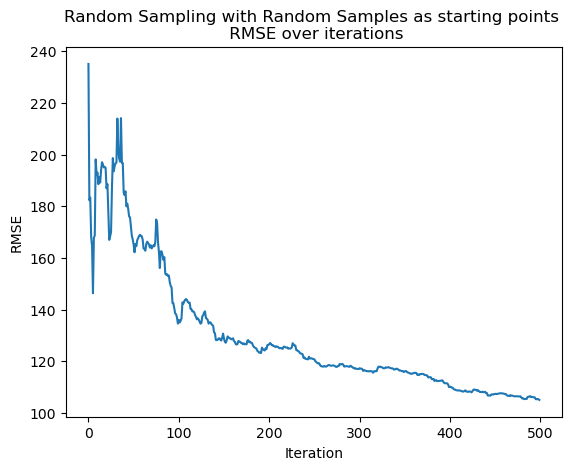

In [126]:
# Active Learning (PLS) with random sampling

pls = PLSRegression(**params_pls)

X_Pool = X_train
y_Pool = y_train
n_samples = 8

X_Learned = None
y_Learned = None

X_Pool, X_Learned, y_Pool, y_Learned = train_test_split(
    X_Pool, y_Pool, test_size=n_samples, random_state=random_state
)

pls.fit(X_Learned, y_Learned)
# calc initial rmse
y_pred = pls.predict(X_test)
rmse = rmse_func(y_test, y_pred)
print(f"Initial RMSE with random sampling: {rmse}, with {len(y_Learned)} samples")

# define the number of iterations
n_iterations = 500

# define the number of samples to be selected in each iteration
n_samples_per_iteration = 1

# to track the samples, we will generate lists, with all the indexes

X_Learned_index = X_Learned.index
# these should be the same as the y_Learned index
y_Learned_index = y_Learned.index
X_Pool_index = X_Pool.index
y_Pool_index = y_Pool.index

rmse_sampling = np.zeros(n_iterations)

# Active Learning Loop
for it in range(n_iterations):
    # select a random sample from the pool by selecting a random index from X_Pool
    random_sample_index = np.random.choice(X_Pool.index)

    x_new = X_Pool.loc[[random_sample_index]]
    y_new = y_Pool.loc[[random_sample_index]]
    # add the sample to the learned set
    X_Learned = pd.concat([X_Learned, x_new])
    y_Learned = pd.concat([y_Learned, y_new])
    # remove the sample from the pool
    X_Pool = X_Pool.drop(index=random_sample_index)
    y_Pool = y_Pool.drop(index=random_sample_index)
    # retrain model on the new full data set and predict a new fit
    pls.fit(X_Learned, y_Learned)
    y_pred = pls.predict(X_test)
    rmse_sampling[it] = rmse_func(y_test, y_pred)
    # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

print(
    f"Final RMSE with random sampling: {rmse_sampling[-1]}, with {len(y_Learned)} samples"
)
rmse_sampling_random_start = rmse_sampling

# plot the rmse over the iterations
plt.plot(range(n_iterations), rmse_sampling)
plt.title(
    "Random Sampling with Random Samples as starting points \n RMSE over iterations"
)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

Initial RMSE with random sampling: 180.4347294193313, with 8 samples
Final RMSE with random sampling: 104.35743501464349, with 508 samples


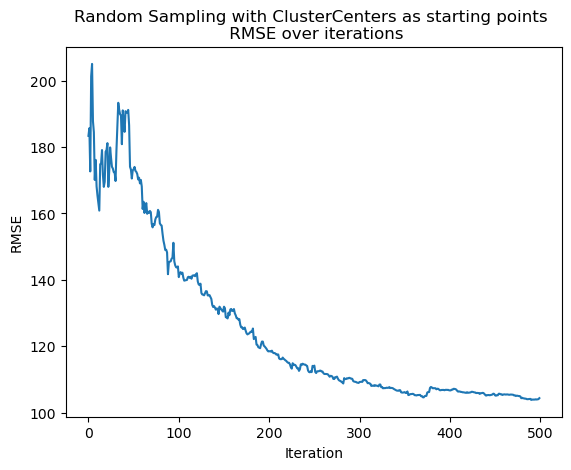

In [127]:
# Active Learning (PLS) with Cluster Centers as starting points

pls = PLSRegression(**params_pls)

X_Pool = X_train
y_Pool = y_train

X_Learned = None
y_Learned = None

# add the samples nearest to cluster centers to the learned set
X_Learned = X_Pool.iloc[initial_samples_sample_ids]
y_Learned = y_Pool.iloc[initial_samples_sample_ids]

# remove the samples from the pool
X_Pool = X_Pool.drop(X_Learned.index)
y_Pool = y_Pool.drop(y_Learned.index)

pls.fit(X_Learned, y_Learned)
# calc initial rmse
y_pred = pls.predict(X_test)
rmse_init = rmse_func(y_test, y_pred)
print(f"Initial RMSE with random sampling: {rmse_init}, with {len(y_Learned)} samples")

# define the number of iterations
n_iterations = 500

# define the number of samples to be selected in each iteration
n_samples_per_iteration = 1

# to track the samples, we will generate lists, with all the indexes
X_Learned_index = X_Learned.index
y_Learned_index = y_Learned.index
X_Pool_index = X_Pool.index
y_Pool_index = y_Pool.index

rmse_sampling = np.zeros(n_iterations)

# Active Learning Loop
for it in range(n_iterations):
    # select a random sample from the pool by selecting a random index from X_Pool
    random_sample_index = np.random.choice(X_Pool.index)
    x_new = X_Pool.loc[[random_sample_index]]
    y_new = y_Pool.loc[[random_sample_index]]
    # add the sample to the learned set
    X_Learned = pd.concat([X_Learned, x_new])
    y_Learned = pd.concat([y_Learned, y_new])
    # remove the sample from the pool
    X_Pool = X_Pool.drop(index=random_sample_index)
    y_Pool = y_Pool.drop(index=random_sample_index)
    # retrain model on the new full data set and predict a new fit
    pls.fit(X_Learned, y_Learned)
    y_pred = pls.predict(X_test)
    rmse_sampling[it] = rmse_func(y_test, y_pred)
    # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

print(
    f"Final RMSE with random sampling: {rmse_sampling[-1]}, with {len(y_Learned)} samples"
)

rmse_sampling_cluster_start = rmse_sampling

# plot the rmse over the iterations
plt.plot(range(n_iterations), rmse_sampling)
plt.title(
    "Random Sampling with ClusterCenters as starting points \n RMSE over iterations"
)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

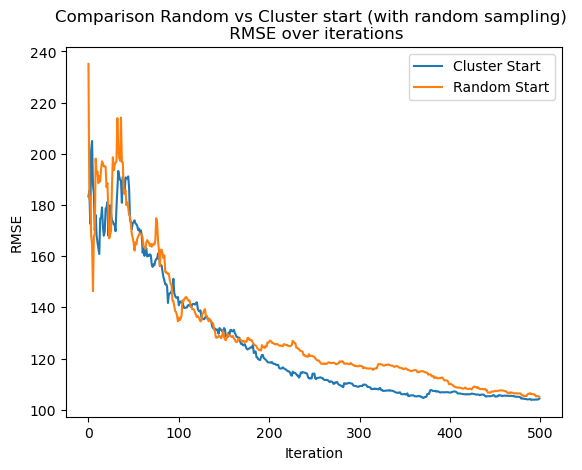

In [128]:
# combine the two plots
# plot the rmse over the iterations
plt.plot(range(n_iterations), rmse_sampling_cluster_start)
plt.plot(range(n_iterations), rmse_sampling_random_start)
plt.title(
    "Comparison Random vs Cluster start (with random sampling) \n RMSE over iterations"
)
plt.legend(["Cluster Start", "Random Start"])
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

# Active Learning with Random sampling - Defining a function

In [129]:
X_Pool = X_train
y_Pool = y_train
random_sample_index = np.random.choice(X_Pool.index)

x_new = X_Pool.loc[[random_sample_index]]
y_new = y_Pool.loc[[random_sample_index]]
random_sample_index, x_new, y_new

(np.int64(118),
          2970      2968          2966      2964     2962      2960      2959  \
 118  0.000011  0.000003 -9.921480e-07  0.000003  0.00001  0.000019  0.000026   
 
          2957      2955      2953  ...       818       816       814  \
 118  0.000027  0.000024  0.000021  ...  0.000011 -0.000012 -0.000035   
 
           812       810       808       806       804      802       800  
 118 -0.000055 -0.000068 -0.000072 -0.000069 -0.000057 -0.00004 -0.000023  
 
 [1 rows x 410 columns],
 118    1982
 Name: year, dtype: int64)

In [130]:
# PLS regression with random sampling as selection criterion


def pls_random(X_train, y_train, n_iterations, params_pls, n_samples_per_it=None):
    """
    Function to perform PLS regression with random sampling as selection criterion
    """
    if n_samples_per_it is None:
        n_samples_per_it = 1
    # initialize the model
    # Define the Input
    # Data
    X_Pool = X_train
    y_Pool = y_train
    # Model
    pls = PLSRegression(**params_pls)

    # Number of iterations of active learning
    if n_iterations is None:
        n_iterations = 50

    # Define the Output
    # RMSE for each iteration
    # Index of the samples selected in each iteration

    rmse_sampling = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)

    # Active Learning Loop
    for it in range(n_iterations):
        # select a random sample from the pool by selecting a random index from X_Pool
        random_sample_index = np.random.choice(X_Pool.index)
        samples_selected[it] = random_sample_index

        x_new = X_Pool.loc[[random_sample_index]]
        y_new = y_Pool.loc[[random_sample_index]]

        # if it = 0, initialize the learned set as empty
        if it == 0:
            X_Learned = pd.DataFrame()
            y_Learned = pd.DataFrame()

        # add the sample to the learned set
        X_Learned = pd.concat([X_Learned, x_new])
        y_Learned = pd.concat([y_Learned, y_new])
        # remove the sample from the pool
        X_Pool = X_Pool.drop(index=random_sample_index)
        y_Pool = y_Pool.drop(index=random_sample_index)
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        if it % n_samples_per_it == 0 and it != 0:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

    print(
        f"Final RMSE with random sampling: {round(rmse_sampling[-1], 3)}, with {len(y_Learned)} samples"
    )

    # calc the rmse for the model including all training data
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)
    print(
        f"RMSE with all training samples: {round(rmse_full, 3)} (with training on {len(y_train)} samples)"
    )

    # plot the rmse over the iterations
    plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # add a line for the model with all training samples
    plt.axhline(y=rmse_full, color="r", linestyle="--")
    plt.title(
        "Random Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.show()

    # create a plot of the rmse as accuracy over the iterations

    # define max acc as rmse_full
    max_acc = rmse_full
    # calculate the accuracy for each iteration
    rmse_acc = max_acc - rmse_sampling
    # plot the accuracy over the iterations
    plt.plot(range(n_iterations)[1:], rmse_acc[1:])
    plt.axhline(y=0, color="r", linestyle="--")  # rmse_full == max_acc
    plt.xlim(1, n_iterations)
    plt.ylim(np.min(rmse_acc), 0 + 10)
    plt.title(
        "Random Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.show()
    # return rmse_sampling, samples_selected

Final RMSE with random sampling: 107.747, with 500 samples
RMSE with all training samples: 102.874 (with training on 812 samples)


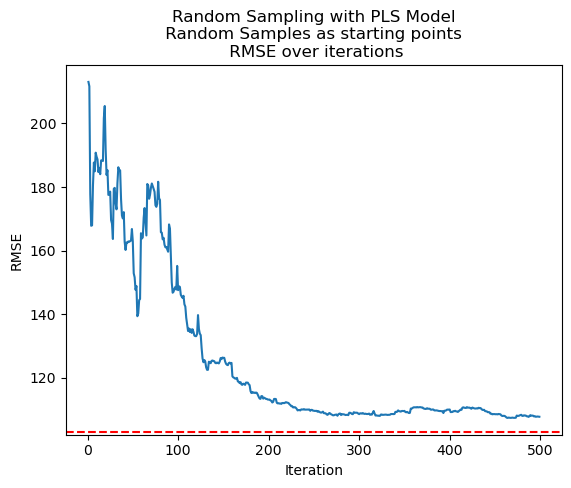

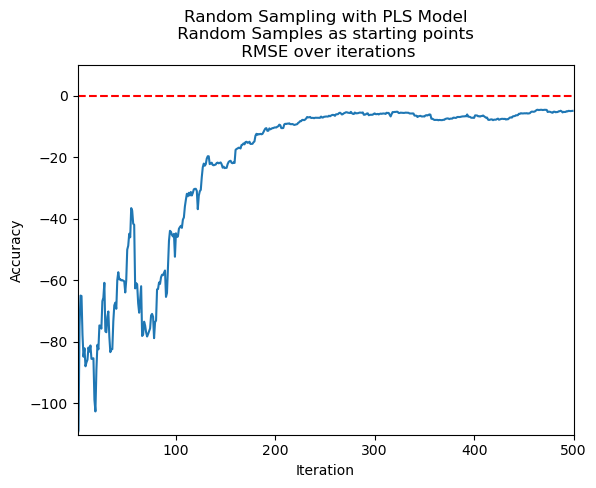

In [131]:
pls_random(X_Pool, y_Pool, 500, params_pls=params_pls)

## GSx

The greedy sampling technique can be described as a max distance sampling. Therfor select samples which are most distant from each sample of the test set. The index specifies the 'direction' in which the samples are measured, X refers to the known Variables and y to the targets.

/tmp/ipykernel_1133100/2874390818.py:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)


Final RMSE with GSx sampling: 110.126, with 510 samples
RMSE with all training samples: 102.874 (with training on 812 samples)


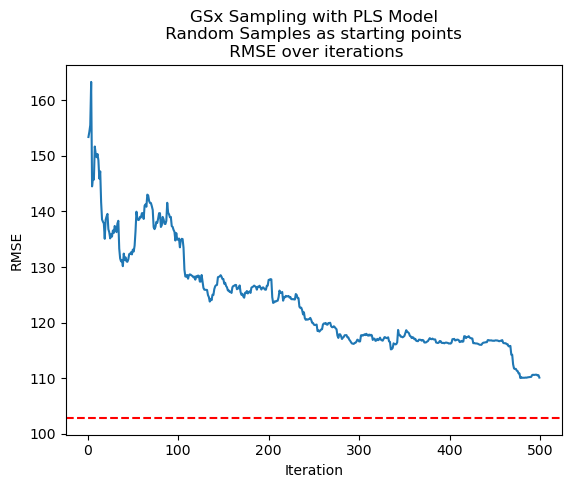

In [132]:
# PLS regression with GSx as selection criterion

# Number of iterations of active learning
n_iterations = 500


def pls_gsx(
    X_train,
    y_train,
    params_pls,
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
):
    """
    Function to perform PLS regression with GSx as selection criterion
    TODO
    """
    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    # initialize the model
    # Define the Input
    # Data
    X_Pool = X_train
    y_Pool = y_train
    # Model
    pls = PLSRegression(**params_pls)

    # Define the Output
    # RMSE for each iteration
    # Index of the sample selected (in each iteration)
    rmse_sampling = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()
    # add initial samples to the learned set (random)
    for _ in range(init_sample_size):
        random_sample_index = np.random.choice(X_Pool.index)
        x_new = X_Pool.loc[[random_sample_index]]
        y_new = y_Pool.loc[[random_sample_index]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=random_sample_index)
        y_Pool = y_Pool.drop(index=random_sample_index)
    assert all(y_Learned.index == X_Learned.index)

    # Active Learning Loop
    for it in range(n_iterations):
        # Greedy Sampling by Euclidean Distance
        # select the sample from X_Pool, where the euclidean distance to the samples in X_Pool is the largest
        # this is done by calculating the euclidean distance between the samples in X_Pool and the samples in X_Learned
        # the sample with the largest distance is selected
        distances = euclidean_distances(
            X_Pool, X_Learned
        )  # distances : ndarray of shape (n_samples_X, n_samples_Y)
        distances_df = pd.DataFrame(
            distances, index=X_Pool.index, columns=X_Learned.index
        )
        # select the sample with the largest distance
        sample_id = distances_df.sum(axis=1).idxmax()
        samples_selected[it] = sample_id
        # retrieve the sample from the pool
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]

        # add the sample to the learned set
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        # remove the sample from the pool
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        if it % n_samples_per_it == 0 and it != 0:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

    print(
        f"Final RMSE with GSx sampling: {round(rmse_sampling[-1], 3)}, with {len(y_Learned)} samples"
    )

    gsx_rmse_sampling = rmse_sampling
    # calc the rmse for the model including all training data
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)
    print(
        f"RMSE with all training samples: {round(rmse_full, 3)} (with training on {len(y_train)} samples)"
    )

    # plot the rmse over the iterations
    plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # add a line for the model with all training samples
    plt.axhline(y=rmse_full, color="r", linestyle="--")
    plt.title(
        "GSx Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.show()
    return gsx_rmse_sampling


gsx_rmse_sampling = pls_gsx(X_Pool, y_Pool, params_pls=params_pls, n_iterations=500)

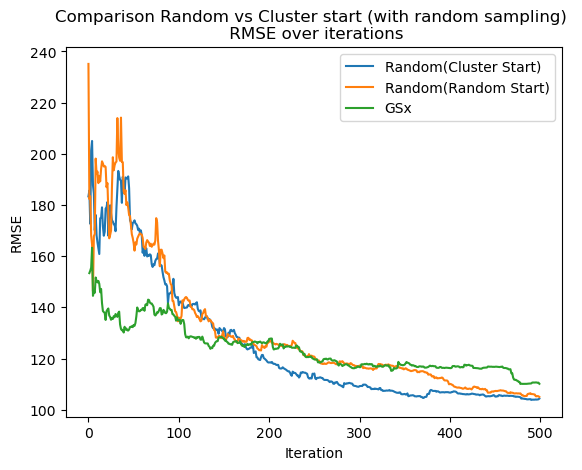

In [133]:
# Compare random sampling with GSx sampling

# plot the rmse over the iterations
plt.plot(range(n_iterations), rmse_sampling_cluster_start)
plt.plot(range(n_iterations), rmse_sampling_random_start)
plt.plot(range(n_iterations)[1:], gsx_rmse_sampling[1:])
plt.title(
    "Comparison Random vs Cluster start (with random sampling) \n RMSE over iterations"
)
plt.legend(["Random(Cluster Start)", "Random(Random Start)", "GSx"])
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

## GSy

Another approach to greedy sampling in X is Greedy Sampling in Y. This variant of a GS algorithm includes an prediction for each sample in the pool. Afterwards the prediction is used to calculate a selection criteria, where the sample with the prediction furthest from the known sample is used. 

In [134]:
# PLS regression with GSy as selection criterion

# Number of iterations of active learning
n_iterations = 500


def pls_gsy(
    X_train,
    y_train,
    params_pls,
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
):
    """
    Function to perform PLS regression with GSx as selection criterion
    TODO
    """
    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    # initialize the model
    # Define the Input
    # Data
    X_Pool = X_train
    y_Pool = y_train
    # Model
    pls = PLSRegression(**params_pls)

    # Define the Output
    # RMSE for each iteration
    # Index of the sample selected (in each iteration)
    rmse_sampling = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()
    # add initial samples to the learned set (random)
    for _ in range(init_sample_size):
        random_sample_index = np.random.choice(X_Pool.index)
        x_new = X_Pool.loc[[random_sample_index]]
        y_new = y_Pool.loc[[random_sample_index]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=random_sample_index)
        y_Pool = y_Pool.drop(index=random_sample_index)
    assert all(y_Learned.index == X_Learned.index)

    pls.fit(X_Learned, y_Learned)
    # Active Learning Loop
    for it in range(n_iterations):
        y_pred_pool = pls.predict(X_Pool)
        #convert y_pred_pool to a pandas dataframe
        y_pred_pool = pd.Series(y_pred_pool, index=X_Pool.index)

        # prepare dataframe for the distances
        distances = pd.DataFrame(index=X_Pool.index, columns=X_Learned.index)
        # calculate the distances for each sample in X_Pool to all samples in y_Learned
        for row in distances.index:
            for col in distances.columns:
                distances.loc[row, col] = np.linalg.norm(
                    y_pred_pool.loc[row] - y_Learned.loc[col]
                    )

        # distances: 
            # index: X_Pool.index
            # columns: X_Learned.index
        # calculate the minimum distance for each sample in X_Pool
        distances['min_dist_per_sample'] = distances.min(axis=1)
        # min_dist_per_sample:
            # index: X_Pool.index
            # value: minimum distance to the samples in y_Learned
        # retrieve the sample_id with the largest minimum distance
        sample_id = distances['min_dist_per_sample'].idxmax()

        # select the sample with the largest min_dist_per_sample
        samples_selected[it] = sample_id
        # retrieve the sample from the pool
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]

        # add the sample to the learned set
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        # remove the sample from the pool
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        if it % n_samples_per_it == 0 and it != 0:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

    print(
        f"Final RMSE with GSy sampling: {round(rmse_sampling[-1], 3)}, with {len(y_Learned)} samples"
    )

    gsy_rmse_sampling = rmse_sampling
    # calc the rmse for the model including all training data
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)
    print(
        f"RMSE with all training samples: {round(rmse_full, 3)} (with training on {len(y_train)} samples)"
    )

    # plot the rmse over the iterations
    plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # add a line for the model with all training samples
    plt.axhline(y=rmse_full, color="r", linestyle="--")
    plt.title(
        "GSy Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.show()
    return gsy_rmse_sampling


gsy_rmse_sampling = pls_gsy(X_Pool, y_Pool, params_pls=params_pls, n_iterations=500)

/tmp/ipykernel_1133100/345312677.py:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)


In [ ]:
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
rmse_full = rmse_func(y_test, y_pred)

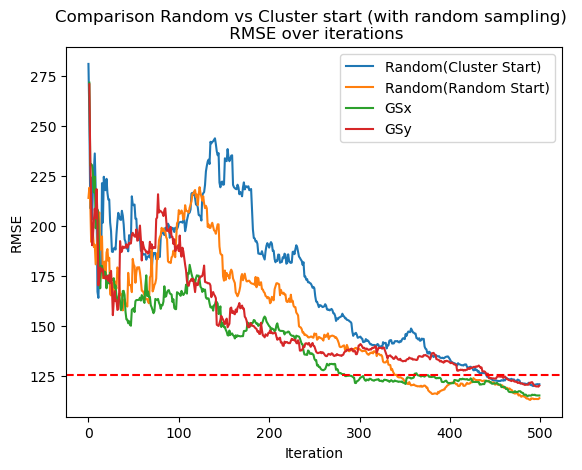

In [ ]:
# Add GSy sampling to the comparison plot

# plot the rmse over the iterations
plt.plot(range(n_iterations), rmse_sampling_cluster_start)
plt.plot(range(n_iterations), rmse_sampling_random_start)
plt.plot(range(n_iterations)[1:], gsx_rmse_sampling[1:])
plt.plot(range(n_iterations)[1:], gsy_rmse_sampling[1:])
plt.axhline(y=rmse_full, color="r", linestyle="--")
plt.title(
    "Comparison Random vs Cluster start (with random sampling) \n RMSE over iterations"
)
plt.legend(["Random(Cluster Start)", "Random(Random Start)", "GSx", "GSy"])
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.savefig(FIGURE_PATH + "/comparison_sampling_methods(500)_with_hline.png")
plt.show()

## Sampling strategy as a function

To streamline the extension of models, the goal is to provide the model and the selection strategy as a function. 

### The model functions

These are already functions, hence the inputs and the functionality needs to be changed accordingly. To implement various models, we need to 

/tmp/ipykernel_148589/873164699.py:47: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)


Final RMSE with GSy sampling: 146.196, with 60 samples
RMSE with all training samples: 125.083 (with training on 802 samples)


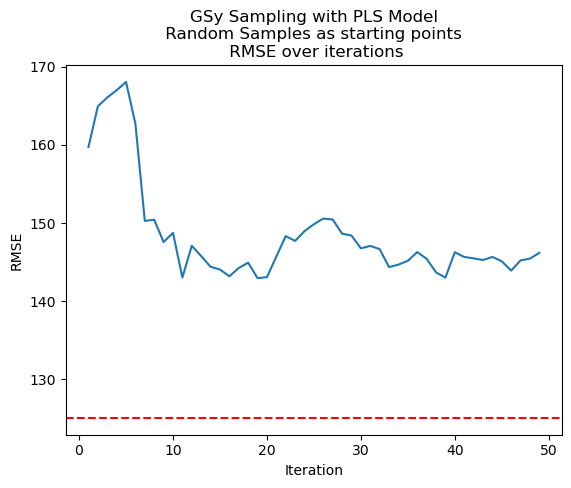

In [ ]:
# Flexibility of the Active Learning Framework
#  Model Class

def gsy(
    X_train,
    y_train,
    model_class = None,
    model_params = {},
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
):
    """
    Function to perform PLS regression with GSx as selection criterion
    TODO
    """
    if model_class is None:
        raise ValueError("No model_class provided")
    if model_params is None:
        # break if no model parameters are provided
        raise ValueError("No model parameters provided")
    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    # initialize the model
    # Define the Input
    # Data
    X_Pool = X_train
    y_Pool = y_train
    # Model
    model = model_class(**model_params)

    # Define the Output
    # RMSE for each iteration
    # Index of the sample selected (in each iteration)
    rmse_sampling = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()
    # add initial samples to the learned set (random)
    for _ in range(init_sample_size):
        random_sample_index = np.random.choice(X_Pool.index)
        x_new = X_Pool.loc[[random_sample_index]]
        y_new = y_Pool.loc[[random_sample_index]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=random_sample_index)
        y_Pool = y_Pool.drop(index=random_sample_index)
    assert all(y_Learned.index == X_Learned.index)

    pls.fit(X_Learned, y_Learned)
    # Active Learning Loop
    for it in range(n_iterations):
        y_pred_pool = pls.predict(X_Pool)
        #convert y_pred_pool to a pandas dataframe
        y_pred_pool = pd.Series(y_pred_pool, index=X_Pool.index)

        # prepare dataframe for the distances
        distances = pd.DataFrame(index=X_Pool.index, columns=X_Learned.index)
        # calculate the distances for each sample in X_Pool to all samples in y_Learned
        for row in distances.index:
            for col in distances.columns:
                distances.loc[row, col] = np.linalg.norm(
                    y_pred_pool.loc[row] - y_Learned.loc[col]
                    )

        # distances: 
            # index: X_Pool.index
            # columns: X_Learned.index
        # calculate the minimum distance for each sample in X_Pool
        distances['min_dist_per_sample'] = distances.min(axis=1)
        # min_dist_per_sample:
            # index: X_Pool.index
            # value: minimum distance to the samples in y_Learned
        # retrieve the sample_id with the largest minimum distance
        sample_id = distances['min_dist_per_sample'].idxmax()

        # select the sample with the largest min_dist_per_sample
        samples_selected[it] = sample_id
        # retrieve the sample from the pool
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]

        # add the sample to the learned set
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        # remove the sample from the pool
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        if it % n_samples_per_it == 0 and it != 0:
            pls.fit(X_Learned, y_Learned)
            y_pred = pls.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

    print(
        f"Final RMSE with GSy sampling: {round(rmse_sampling[-1], 3)}, with {len(y_Learned)} samples"
    )

    gsy_rmse_sampling = rmse_sampling
    # calc the rmse for the model including all training data
    pls.fit(X_train, y_train)
    y_pred = pls.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)
    print(
        f"RMSE with all training samples: {round(rmse_full, 3)} (with training on {len(y_train)} samples)"
    )

    # plot the rmse over the iterations
    plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # add a line for the model with all training samples
    plt.axhline(y=rmse_full, color="r", linestyle="--")
    plt.title(
        "GSy Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.show()
    return gsy_rmse_sampling

gsy_function_test = gsy(X_train = X_Pool, y_train = y_Pool, model_class = PLSRegression, model_params=params_pls, n_iterations=50)

In [ ]:
# Flexibility of the Active Learning Framework
# Selection Criteria

def gsy_selection_(X_Pool, X_Learned, y_Learned, y_pred_pool) -> int: 
    """_summary_

    Args:
        X_Pool (_type_): _description_
        X_Learned (_type_): _description_
        y_Learned (_type_): _description_
        y_pred_pool (_type_): _description_

    Returns:
        _type_: _description_
    """
    # prepare dataframe for the distances
    distances = pd.DataFrame(index=X_Pool.index, columns=X_Learned.index)
    # calculate the distances for each sample in X_Pool to all samples in y_Learned
    for row in distances.index:
        for col in distances.columns:
            distances.loc[row, col] = np.linalg.norm(
                y_pred_pool.loc[row] - y_Learned.loc[col]
                )

    # distances: 
        # index: X_Pool.index
        # columns: X_Learned.index
    # calculate the minimum distance for each sample in X_Pool
    distances['min_dist_per_sample'] = distances.min(axis=1)
    # min_dist_per_sample:
        # index: X_Pool.index
        # value: minimum distance to the samples in y_Learned
    # retrieve the sample_id with the largest minimum distance
    sample_id = distances['min_dist_per_sample'].idxmax()
    return sample_id

def gsy(
    X_train,
    y_train,
    model_class = None,
    model_params = {},
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
):
    """
    Function to perform any regression method with GSy as selection criterion
    TODO
    """
    if model_class is None:
        raise ValueError("No model_class provided")
    if model_params is None:
        # break if no model parameters are provided
        raise ValueError("No model parameters provided")
    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    # initialize the model
    # Define the Input
    # Data
    X_Pool = X_train
    y_Pool = y_train
    # Model
    model = model_class(**model_params)

    # Define the Output
    # RMSE for each iteration
    # Index of the sample selected (in each iteration)
    rmse_sampling = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()
    # add initial samples to the learned set (random)
    for _ in range(init_sample_size):
        random_sample_index = np.random.choice(X_Pool.index)
        x_new = X_Pool.loc[[random_sample_index]]
        y_new = y_Pool.loc[[random_sample_index]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=random_sample_index)
        y_Pool = y_Pool.drop(index=random_sample_index)
    assert all(y_Learned.index == X_Learned.index)

    model.fit(X_Learned, y_Learned)
    # Active Learning Loop
    for it in range(n_iterations):
        y_pred_pool = model.predict(X_Pool)
        #convert y_pred_pool to a pandas dataframe
        y_pred_pool = pd.Series(y_pred_pool, index=X_Pool.index)

        sample_id = gsy_selection_(X_Pool, X_Learned, y_Learned, y_pred_pool)

        # select the sample with the largest min_dist_per_sample
        samples_selected[it] = sample_id
        # retrieve the sample from the pool
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]

        # add the sample to the learned set
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        # remove the sample from the pool
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        if it % n_samples_per_it == 0 and it != 0:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")
        # print(f"RMSE after iteration {it+1}: {rmse_sampling[it]}, with {len(y_Learned)} samples")

    print(
        f"Final RMSE with GSy sampling: {round(rmse_sampling[-1], 3)}, with {len(y_Learned)} samples"
    )

    gsy_rmse_sampling = rmse_sampling
    # calc the rmse for the model including all training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)
    print(
        f"RMSE with all training samples: {round(rmse_full, 3)} (with training on {len(y_train)} samples)"
    )

    # plot the rmse over the iterations
    plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # add a line for the model with all training samples
    plt.axhline(y=rmse_full, color="r", linestyle="--")
    plt.title(
        "GSy Sampling with PLS Model\n Random Samples as starting points \n RMSE over iterations"
    )
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.show()
    return gsy_rmse_sampling

gsy_function_test2 = gsy(X_train = X_Pool, y_train = y_Pool, model_class = PLSRegression, model_params=params_pls, n_iterations=5)

NameError: name 'X_Pool' is not defined